# Project: predicting orders for Glovo

Imagine you just joined Glovo. Glovo follows a slot-based system for the couriers to fullfil the orders that come in. For simplification, you can imagine those slots are non-overlapping hours, so that every every city has 24 slots every day, one for each hour. Glovo needs to know the optimal number of couriers that are needed on every hour slot of every city. Too many couriers, and there will be many idle couriers not earning money. Too few couriers, and orders will have to wait to be processed, leading to higher delivery times.

At the moment, Operations decides manually how many couriers are needed, based on past demand. As the number of cities grows, this becomes unsustainable. They want to automate the process by which they decide how many courier-slots should be opened every hour. For simplification, we can assume that every Sunday at midnight, we need to know how many couriers we need for every hour of the week that is starting. That means that if today is Sunday, May 8th 23:59, they want us to know how many orders will be placed every hour of the week that goes from May 9th 00:00 to May 15th 23:00, both included. Every Sunday, you can use all data from that week to forecast the next one.

This problem has many steps, but we will keep this project to the order forecast for one city: we want to know, for one city and every Sunday, how many orders we're going to receive on every hour of the upcoming week.

## EDA

Load the file data_BCN.csv

Explore the data, visualise it. Look for trends, cycles and seasonalities. Also, can you find any outliers? days or hours that break those patterns?

## Modelling

Try different models. Validate each model in a way that would imitate the real problem (every sunday you forecast all of next week). Watch out for data leakage. Evaluate each model on MSE and SMAPE. Which one performs better?


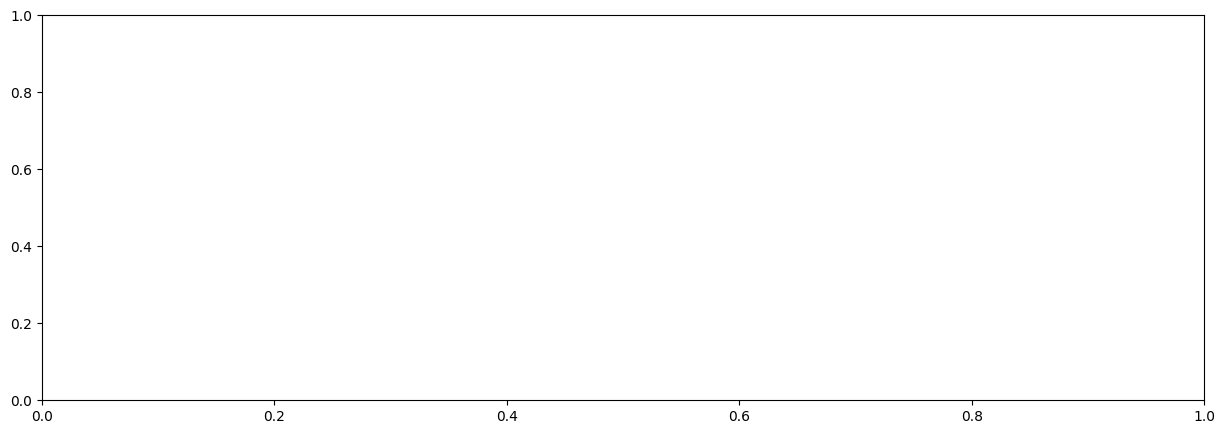

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px

data = pd.read_csv('data/data_BCN.csv')
fig, ax = plt.subplots(figsize=(15, 5))
px.line(data, x='time', y='orders')

### Setting up the data

In [3]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
import numpy as np
from sklearn.metrics import mean_absolute_error

sns.set()
SMALL_SIZE = 12
MEDIUM_SIZE = SMALL_SIZE + 3

plt.rc('font', size=SMALL_SIZE)           # controls default text sizes\\n\",\n",
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title\\n\",\n",
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels\\n\",\n",
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels\\n\",\n",
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels\\n\",\n",
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize\\n\",\n",
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title\\n\",\n",
plt.rc('figure', figsize=(7, 2))
plt.rc('figure', dpi=200)

In [4]:
# Loading data 
glovo = pd.read_csv("data/data_BCN.csv")
print(glovo.shape)
glovo.head()

(8766, 3)


,time,orders,city
0,2021-02-01 00:00:00,0.0,BCN
1,2021-02-01 01:00:00,0.0,BCN
2,2021-02-01 02:00:00,0.0,BCN
3,2021-02-01 03:00:00,0.0,BCN
4,2021-02-01 04:00:00,0.0,BCN


In [5]:
TARGET = "orders"

In [6]:
glovo[[TARGET]].describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
orders,8766.0,73.15,111.04,0.0,0.0,30.0,97.0,939.0


array([[<Axes: title={'center': 'orders'}>]], dtype=object)

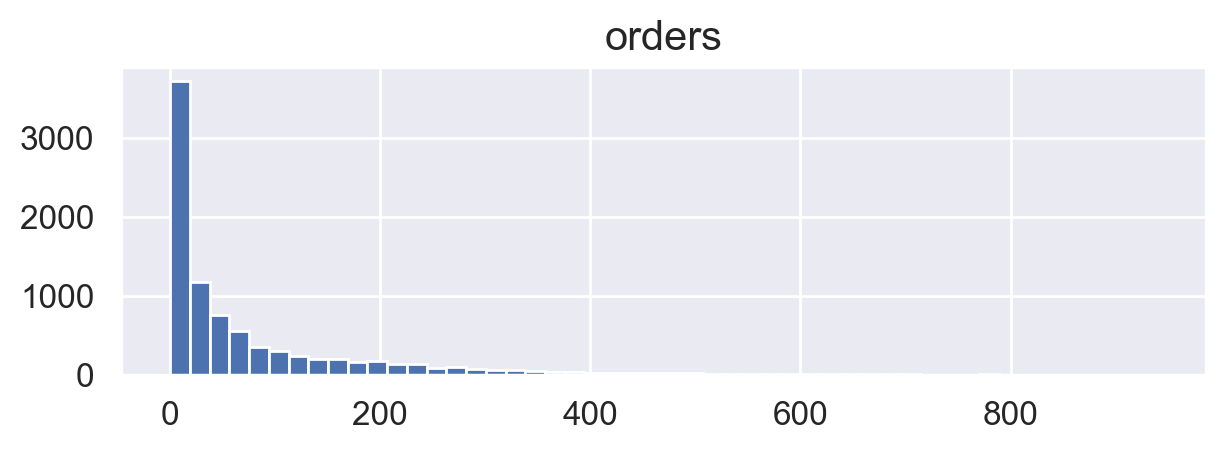

In [7]:
glovo[[TARGET]].hist(bins=50)

We can see that there are a lot of zeros in the data, which means that the distribution is sparse/zero-inflated.
We can see that the mean is higher than the median, which means that the distribution is skewed to the right.

Implications for modelling:
- If we can avoid predicting at a minute-level, we should.
- If not, predicting the mean is not a good idea, so a linear model might not be a good idea.
- If we want to use a linear model, we could to split the problem in two: predict whether there is consumption or not, and then predict the amount of consumption.
- Otherwise we could use a non-linear model, like a tree-based model.

For the sake of this analysis, we're going to aggregate data to a 5 minute level resolution, but first we'll check for missing data.

In [11]:
glovo['time'].value_counts().sort_values()

time
2021-02-01 00:00:00    1
2021-02-01 04:00:00    1
2021-02-01 05:00:00    1
2021-02-01 06:00:00    1
2021-02-01 07:00:00    1
                      ..
2022-02-01 13:00:00    1
2022-02-01 12:00:00    1
2022-02-01 11:00:00    1
2022-02-01 17:00:00    1
2022-02-01 23:00:00    1
Name: count, Length: 8766, dtype: int64

In [27]:
glovo['time'] = pd.to_datetime(glovo['time'])
glovo = glovo.set_index('time')

In [28]:
glovo_agg = glovo.resample('H')[[TARGET]].sum()
glovo_agg['time'] = glovo_agg.index.date
glovo_agg.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
orders,8784.0,73.0,110.97,0.0,0.0,30.0,96.0,939.0


In [30]:
glovo_agg['time'].value_counts().value_counts()

count
24    366
Name: count, dtype: int64

In [31]:
glovo_agg.isnull().sum()

orders    0
time      0
dtype: int64

array([[<Axes: title={'center': 'orders'}>]], dtype=object)

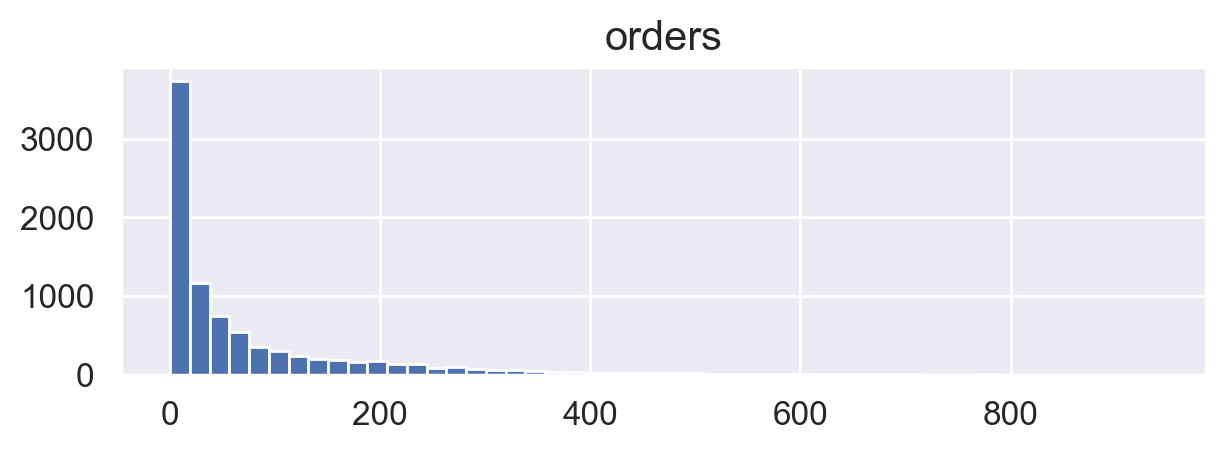

In [32]:
glovo_agg.hist(bins=50)

### EXPLORATORY DATA ANALYSIS
Look for trends, cycles, and seasonalities